In [1]:
# ================================================================
# LGBM + XGBoost + CatBoost + Optuna Ensemble
# For train_final.csv / test_final.csv  (CMI PIU-style tabular)
# ================================================================

import os
import joblib
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    cohen_kappa_score,
    accuracy_score,
    f1_score,
    confusion_matrix
)

import optuna
from optuna.samplers import TPESampler

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

plt.style.use("seaborn-v0_8")

RANDOM_STATE = 42
N_SPLITS = 5
N_TRIALS_PER_MODEL = 80  # Option B
np.random.seed(RANDOM_STATE)

In [2]:
# ================================================================
# 1. Load data & detect target
# ================================================================
train_path = "train_final.csv"
test_path  = "test_final.csv"

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

print("Train shape:", train.shape)
print("Test  shape:", test.shape)

# ---- Target auto-detection ----
possible_targets = ["sii", "target", "label", "PIU", "risk_score"]
target_col = None
for col in possible_targets:
    if col in train.columns:
        target_col = col
        break

if target_col is None:
    # Fallback: lowest-unique integer column
    int_cols = [c for c in train.columns if str(train[c].dtype).startswith("int")]
    int_cols_uniq = sorted(int_cols, key=lambda c: train[c].nunique())
    target_col = int_cols_uniq[0]

print(f"Detected target column: {target_col}")

y = train[target_col].astype(int).values
X = train.drop(columns=[target_col])
X_test = test.copy()

classes = np.unique(y)
print("Classes:", classes)

Train shape: (2736, 288)
Test  shape: (20, 287)
Detected target column: sii
Classes: [0 1 2 3]


In [3]:
# ================================================================
# 2. Detect categorical features (for CatBoost)
#    - Use known season dummies if present
#    - Otherwise fallback to low-unique int/obj columns
# ================================================================
known_cat_cols = [
    "Basic_Demos-Enroll_Season_spring",
    "Basic_Demos-Enroll_Season_summer",
    "Basic_Demos-Enroll_Season_winter",
    "Physical-Season_spring",
    "Physical-Season_summer",
    "Physical-Season_winter",
    "Fitness_Endurance-Season_missing",
    "Fitness_Endurance-Season_spring",
    "FGC-Season_spring",
    "FGC-Season_summer",
    "FGC-Season_winter",
    "BIA-Season_missing",
    "BIA-Season_spring",
    "BIA-Season_summer",
    "PreInt_EduHx-Season_spring",
    "PreInt_EduHx-Season_summer",
    "PreInt_EduHx-Season_winter",
]

cat_cols = [c for c in known_cat_cols if c in X.columns]

# Fallback: low-unique int/obj/bool
if len(cat_cols) == 0:
    for c in X.columns:
        if (str(X[c].dtype).startswith("int") or str(X[c].dtype) == "bool" or str(X[c].dtype) == "object") \
           and X[c].nunique() <= 10:
            cat_cols.append(c)

cat_features_idx = [X.columns.get_loc(c) for c in cat_cols]
print(f"Detected {len(cat_features_idx)} categorical columns for CatBoost:", cat_cols)

# For LGBM/XGB we just pass all features as numeric (already encoded)

Detected 17 categorical columns for CatBoost: ['Basic_Demos-Enroll_Season_spring', 'Basic_Demos-Enroll_Season_summer', 'Basic_Demos-Enroll_Season_winter', 'Physical-Season_spring', 'Physical-Season_summer', 'Physical-Season_winter', 'Fitness_Endurance-Season_missing', 'Fitness_Endurance-Season_spring', 'FGC-Season_spring', 'FGC-Season_summer', 'FGC-Season_winter', 'BIA-Season_missing', 'BIA-Season_spring', 'BIA-Season_summer', 'PreInt_EduHx-Season_spring', 'PreInt_EduHx-Season_summer', 'PreInt_EduHx-Season_winter']


In [4]:
# ================================================================
# 3. QWK scorer
# ================================================================
def qwk(y_true, y_pred):
    """Quadratic Weighted Kappa."""
    return cohen_kappa_score(y_true, y_pred, weights="quadratic")


# ================================================================
# 4. Shared CV splitter
# ================================================================
skf = StratifiedKFold(
    n_splits=N_SPLITS,
    shuffle=True,
    random_state=RANDOM_STATE
)

In [ ]:
# ================================================================
# 5. OPTUNA OBJECTIVES
# ================================================================

# --------------------------
# LightGBM Objective
# --------------------------
def objective_lgb(trial):
    params = {
        "objective": "multiclass",
        "num_class": len(classes),
        "metric": "None",  # we use custom QWK
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 16, 64),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 60),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 5),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 5.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 5.0),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 150, 400),
        "random_state": RANDOM_STATE,
        "n_jobs": -1
    }

    fold_qwks = []

    for tr_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y[tr_idx], y[val_idx]

        model = LGBMClassifier(**params)
        model.fit(
            X_tr,
            y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric="multi_logloss",
            callbacks=[],
        )
        preds_val = model.predict(X_val)
        fold_qwks.append(qwk(y_val, preds_val))

    return float(np.mean(fold_qwks))


# --------------------------
# XGBoost Objective
# --------------------------
def objective_xgb(trial):
    params = {
        "objective": "multi:softmax",  # directly predict class labels
        "num_class": len(classes),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 10.0),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "n_estimators": trial.suggest_int("n_estimators", 150, 400),
        "random_state": RANDOM_STATE,
        "tree_method": "hist",
        "n_jobs": -1
    }

    fold_qwks = []

    for tr_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y[tr_idx], y[val_idx]

        model = XGBClassifier(**params)
        model.fit(
            X_tr,
            y_tr,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        preds_val = model.predict(X_val)
        fold_qwks.append(qwk(y_val, preds_val))

    return float(np.mean(fold_qwks))


# --------------------------
# CatBoost Objective
# --------------------------
def objective_cat(trial):
    params = {
        "loss_function": "MultiClass",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "depth": trial.suggest_int("depth", 3, 7),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "random_strength": trial.suggest_float("random_strength", 1.0, 15.0),
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 40),
        "bootstrap_type": "Bernoulli",
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "iterations": trial.suggest_int("iterations", 150, 350),
        "eval_metric": "WKappa",  # CatBoost built-in QWK
        "random_seed": RANDOM_STATE,
        "verbose": False
    }

    fold_qwks = []

    for tr_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y[tr_idx], y[val_idx]

        train_pool = Pool(X_tr, y_tr, cat_features=cat_features_idx)
        val_pool   = Pool(X_val, y_val, cat_features=cat_features_idx)

        model = CatBoostClassifier(**params)
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            verbose=False
        )

        preds_val = model.predict(val_pool).astype(int).ravel()
        fold_qwks.append(qwk(y_val, preds_val))

    return float(np.mean(fold_qwks))

In [ ]:
# ================================================================
# 6. Run Optuna studies
# ================================================================
optuna.logging.set_verbosity(optuna.logging.WARNING)

print("\n================ Optuna: LightGBM ================")
study_lgb = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(seed=RANDOM_STATE)
)
study_lgb.optimize(objective_lgb, n_trials=N_TRIALS_PER_MODEL, show_progress_bar=True)

print("LGBM - Best QWK:", study_lgb.best_value)
print("LGBM - Best params:", study_lgb.best_params)
joblib.dump(study_lgb.best_params, "best_lgb_params.pkl")

print("\n================ Optuna: XGBoost ================")
study_xgb = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(seed=RANDOM_STATE)
)
study_xgb.optimize(objective_xgb, n_trials=N_TRIALS_PER_MODEL, show_progress_bar=True)

print("XGB - Best QWK:", study_xgb.best_value)
print("XGB - Best params:", study_xgb.best_params)
joblib.dump(study_xgb.best_params, "best_xgb_params.pkl")

print("\n================ Optuna: CatBoost ================")
study_cat = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(seed=RANDOM_STATE)
)
study_cat.optimize(objective_cat, n_trials=N_TRIALS_PER_MODEL, show_progress_bar=True)

print("CatBoost - Best QWK:", study_cat.best_value)
print("CatBoost - Best params:", study_cat.best_params)
joblib.dump(study_cat.best_params, "best_cat_params.pkl")

In [8]:
# ================================================================
# 7. Final training with best params (OOF + test preds)
# ================================================================
def train_oof_lgb(best_params, boost_iterations_factor=2.0):
    params = best_params.copy()
    n_estimators = int(params.pop("n_estimators"))
    n_estimators = int(max(200, n_estimators * boost_iterations_factor))

    params.update({
        "objective": "multiclass",
        "num_class": len(classes),
        "metric": "None",
        "boosting_type": "gbdt",
        "random_state": RANDOM_STATE,
        "n_jobs": -1,
        "n_estimators": n_estimators
    })

    oof_pred = np.zeros_like(y, dtype=int)
    test_pred_folds = []
    fold_qwks = []
    feature_importances = np.zeros(X.shape[1])

    for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"[LGBM] Fold {fold+1}/{N_SPLITS}")
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y[tr_idx], y[val_idx]

        model = LGBMClassifier(**params)
        model.fit(
            X_tr,
            y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric="multi_logloss",
            callbacks=[],
        )

        preds_val = model.predict(X_val)
        preds_test = model.predict(X_test)

        oof_pred[val_idx] = preds_val
        test_pred_folds.append(preds_test)

        fold_qwks.append(qwk(y_val, preds_val))
        feature_importances += model.feature_importances_

    test_pred = np.round(np.mean(np.vstack(test_pred_folds), axis=0)).astype(int)
    feature_importances /= N_SPLITS

    return oof_pred, test_pred, np.array(fold_qwks), feature_importances


def train_oof_xgb(best_params, boost_iterations_factor=2.0):
    params = best_params.copy()
    n_estimators = int(params.pop("n_estimators"))
    n_estimators = int(max(200, n_estimators * boost_iterations_factor))

    params.update({
        "objective": "multi:softmax",
        "num_class": len(classes),
        "random_state": RANDOM_STATE,
        "tree_method": "hist",
        "n_jobs": -1,
        "n_estimators": n_estimators
    })

    oof_pred = np.zeros_like(y, dtype=int)
    test_pred_folds = []
    fold_qwks = []
    feature_importances = np.zeros(X.shape[1])

    for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"[XGB] Fold {fold+1}/{N_SPLITS}")
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y[tr_idx], y[val_idx]

        model = XGBClassifier(**params)
        model.fit(
            X_tr,
            y_tr,
            eval_set=[(X_val, y_val)],
            verbose=False
        )

        preds_val = model.predict(X_val)
        preds_test = model.predict(X_test)

        oof_pred[val_idx] = preds_val
        test_pred_folds.append(preds_test)

        fold_qwks.append(qwk(y_val, preds_val))
        feature_importances += model.feature_importances_

    test_pred = np.round(np.mean(np.vstack(test_pred_folds), axis=0)).astype(int)
    feature_importances /= N_SPLITS

    return oof_pred, test_pred, np.array(fold_qwks), feature_importances


def train_oof_cat(best_params, boost_iterations_factor=1.5):
    # --- Fix invalid bootstrap+subsample combos ---
    params = best_params.copy()

    # Force CatBoost to always use Bernoulli if subsample < 1.0
    if "subsample" in params and params["subsample"] < 1.0:
        params["bootstrap_type"] = "Bernoulli"

    # Remove 'bagging_temperature' unless bootstrap_type is Bayesian
    if params.get("bootstrap_type", "Bernoulli") != "Bayesian":
        params.pop("bagging_temperature", None)

    # Expand training iterations
    iters = int(params.pop("iterations"))
    params["iterations"] = int(max(200, iters * boost_iterations_factor))

    # Always set these safe defaults:
    params.update({
        "loss_function": "MultiClass",
        "eval_metric": "WKappa",
        "random_seed": RANDOM_STATE,
        "verbose": False
    })

    print("\n[CatBoost sanitized params]")
    print(params)

    oof_pred = np.zeros_like(y, dtype=int)
    test_pred_folds = []
    fold_qwks = []
    feature_importances = np.zeros(X.shape[1])

    for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"[CatBoost] Fold {fold+1}/{N_SPLITS}")

        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y[tr_idx], y[val_idx]

        train_pool = Pool(X_tr, y_tr, cat_features=cat_features_idx)
        val_pool   = Pool(X_val, y_val, cat_features=cat_features_idx)
        test_pool  = Pool(X_test, cat_features=cat_features_idx)

        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=val_pool, use_best_model=True)

        preds_val = model.predict(val_pool).astype(int).ravel()
        preds_test = model.predict(test_pool).astype(int).ravel()

        oof_pred[val_idx] = preds_val
        test_pred_folds.append(preds_test)

        fold_qwks.append(qwk(y_val, preds_val))
        feature_importances += model.get_feature_importance(train_pool)

    test_pred = np.round(np.mean(np.vstack(test_pred_folds), axis=0)).astype(int)
    feature_importances /= N_SPLITS

    return oof_pred, test_pred, np.array(fold_qwks), feature_importances



print("\n====== Final OOF training with best params ======")

oof_lgb, test_lgb, fold_qwk_lgb, fi_lgb = train_oof_lgb(study_lgb.best_params)
oof_xgb, test_xgb, fold_qwk_xgb, fi_xgb = train_oof_xgb(study_xgb.best_params)
oof_cat, test_cat, fold_qwk_cat, fi_cat = train_oof_cat(study_cat.best_params)

np.save("oof_lgb.npy", oof_lgb)
np.save("oof_xgb.npy", oof_xgb)
np.save("oof_cat.npy", oof_cat)

np.save("test_lgb.npy", test_lgb)
np.save("test_xgb.npy", test_xgb)
np.save("test_cat.npy", test_cat)


====== Final OOF training with best params ======
[LGBM] Fold 1/5
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] feature_fraction is set=0.8690876620662107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8690876620662107
[LightGBM] [Warning] min_gain_to_split is set=0.9961965474603263, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9961965474603263
[LightGBM] [Warning] lambda_l1 is set=1.751675255231039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.751675255231039
[LightGBM] [Warning] lambda_l2 is set=3.8403546849159995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8403546849159995
[LightGBM] [Warning] bagging_fraction is set=0.8790270586690763, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8790270586690763
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value

In [9]:

# ================================================================
# 8. Metrics table
# ================================================================
def compute_metrics(y_true, y_pred, fold_qwks):
    cv_mean = np.mean(fold_qwks)
    cv_std  = np.std(fold_qwks)
    best_fold = np.max(fold_qwks)
    oof_q = qwk(y_true, y_pred)
    acc   = accuracy_score(y_true, y_pred)
    f1    = f1_score(y_true, y_pred, average="macro")
    return cv_mean, cv_std, best_fold, oof_q, acc, f1

m_lgb = compute_metrics(y, oof_lgb, fold_qwk_lgb)
m_xgb = compute_metrics(y, oof_xgb, fold_qwk_xgb)
m_cat = compute_metrics(y, oof_cat, fold_qwk_cat)

metrics_df = pd.DataFrame(
    {
        "Model": ["LightGBM", "XGBoost", "CatBoost"],
        "CV_QWK_mean": [m_lgb[0], m_xgb[0], m_cat[0]],
        "CV_QWK_std": [m_lgb[1], m_xgb[1], m_cat[1]],
        "Best_Fold_QWK": [m_lgb[2], m_xgb[2], m_cat[2]],
        "OOF_QWK": [m_lgb[3], m_xgb[3], m_cat[3]],
        "Accuracy": [m_lgb[4], m_xgb[4], m_cat[4]],
        "Macro_F1": [m_lgb[5], m_xgb[5], m_cat[5]],
    }
)

print("\n===== Metrics Table =====")
print(metrics_df.round(4))


===== Metrics Table =====
      Model  CV_QWK_mean  CV_QWK_std  Best_Fold_QWK  OOF_QWK  Accuracy  \
0  LightGBM       0.4050      0.0422         0.4678   0.4048    0.6181   
1   XGBoost       0.4108      0.0469         0.4705   0.4114    0.6181   
2  CatBoost       0.4263      0.0468         0.4934   0.4263    0.6192   

   Macro_F1  
0    0.3469  
1    0.3679  
2    0.3864  


In [10]:
# ================================================================
# 9. Simple ensemble (mean of 3 models)
#    (We treat predictions as ordinal scores and round.)
# ================================================================
blend_oof  = np.round((oof_lgb + oof_xgb + oof_cat) / 3.0).astype(int)
blend_test = np.round((test_lgb + test_xgb + test_cat) / 3.0).astype(int)

blend_qwk = qwk(y, blend_oof)
print(f"\nEnsemble OOF QWK: {blend_qwk:.4f}")


Ensemble OOF QWK: 0.4258


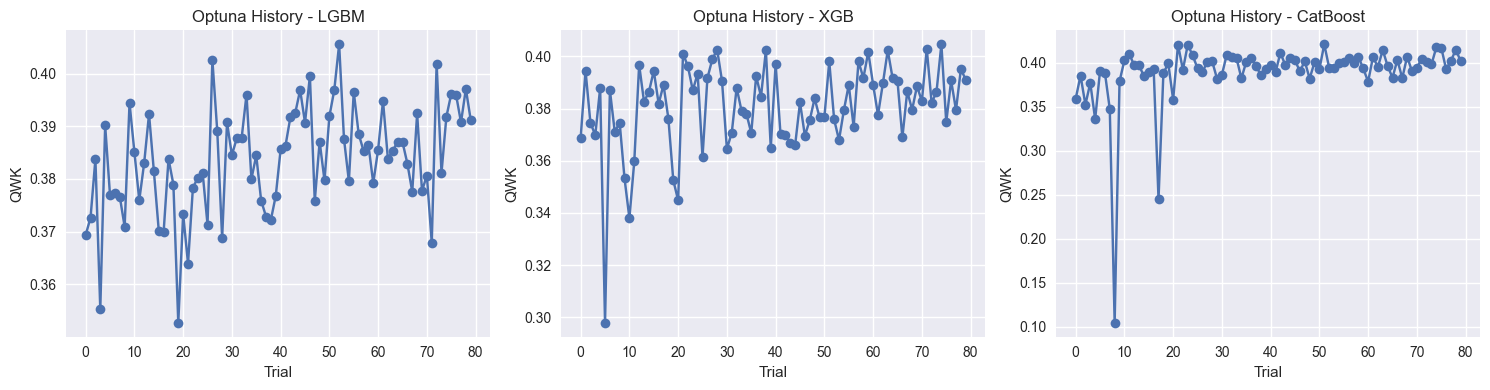

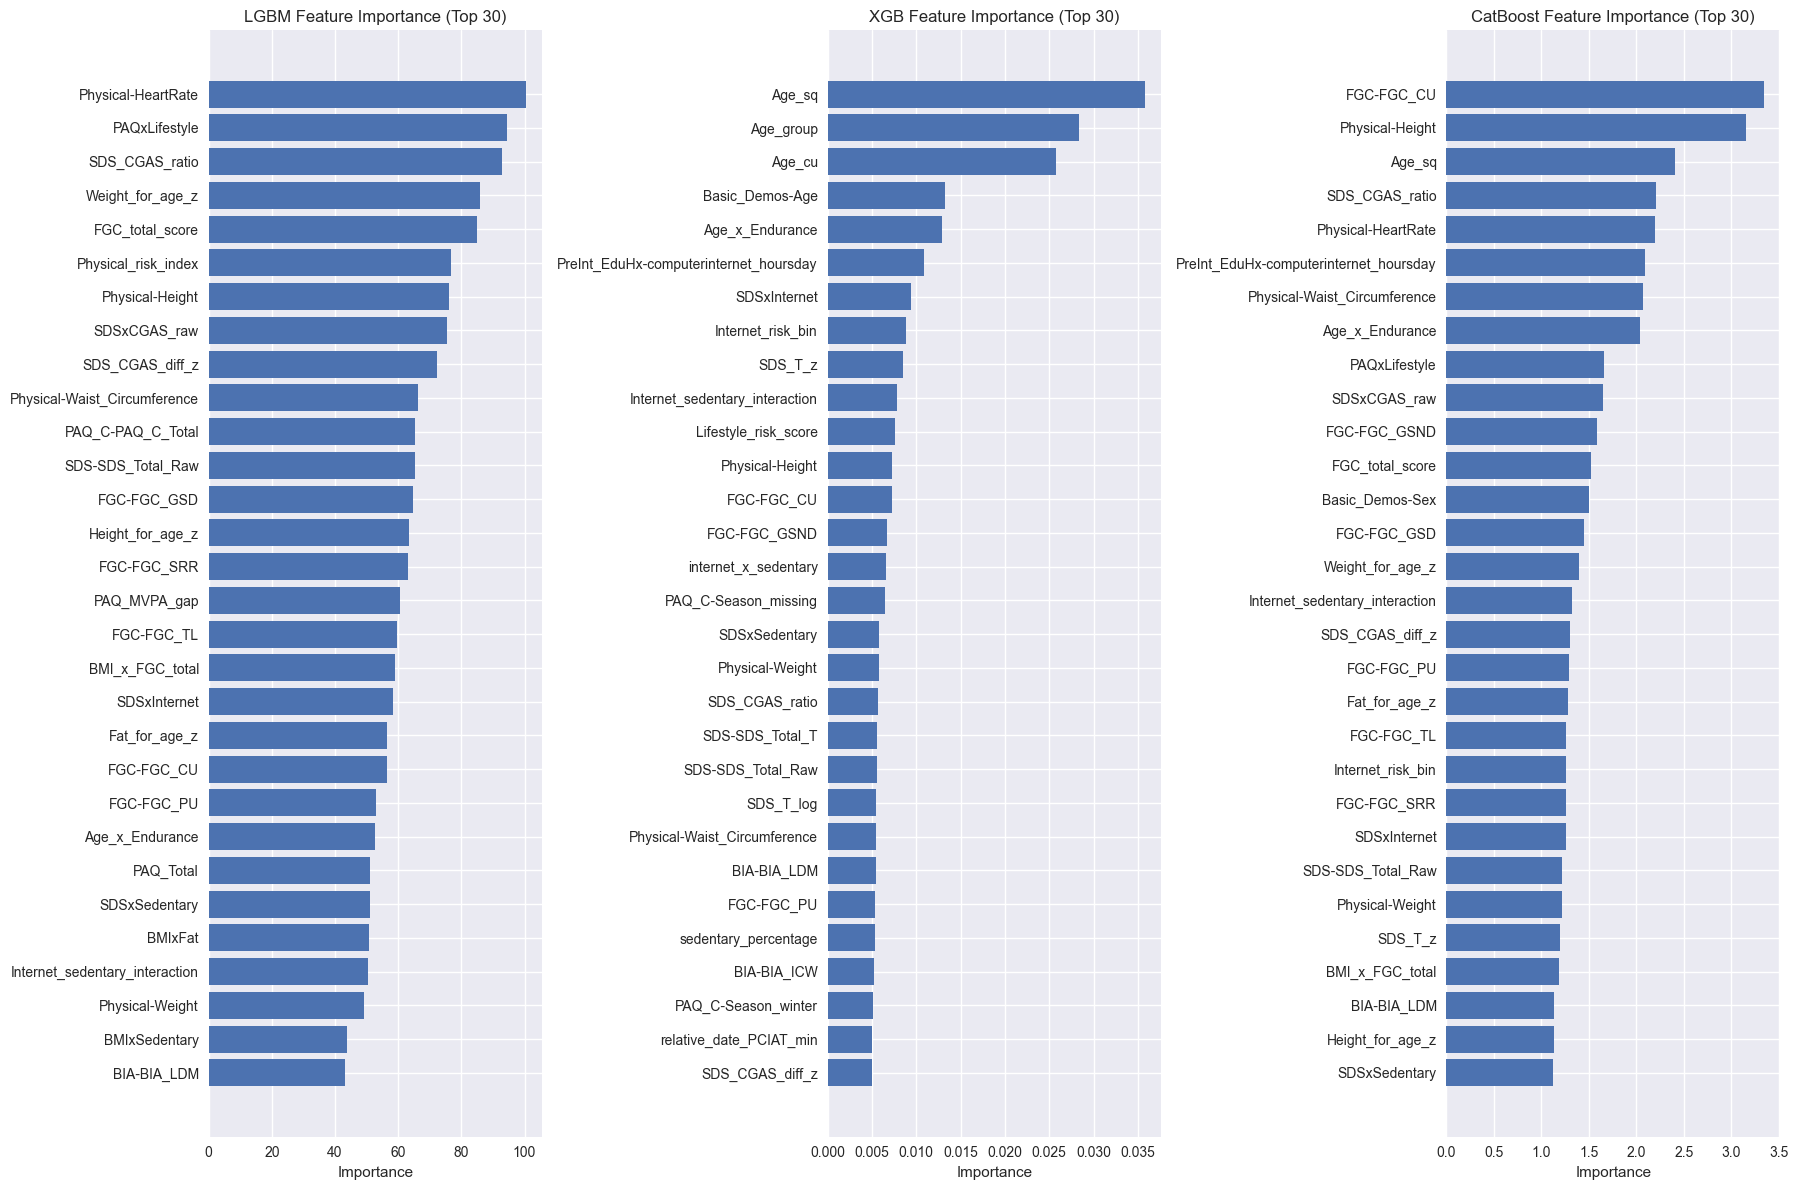

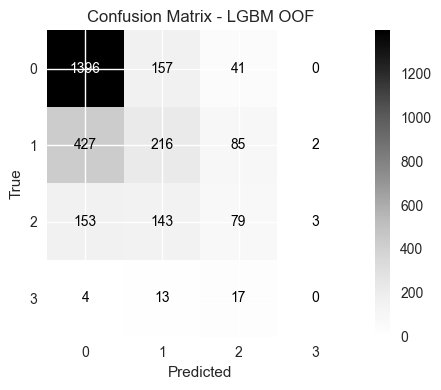

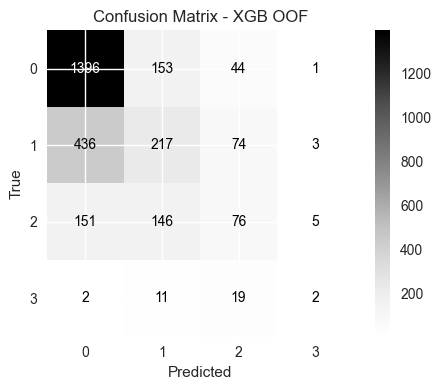

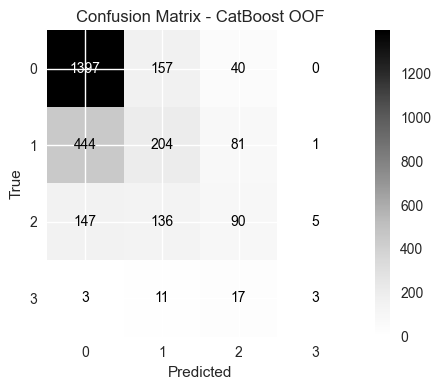

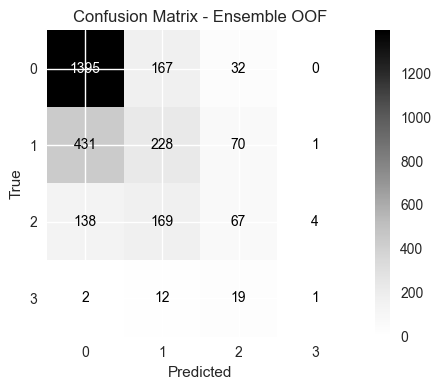

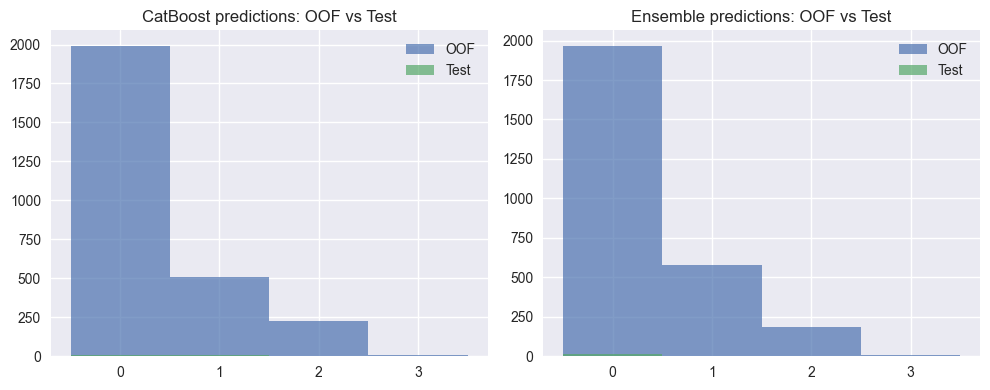

In [11]:
# ================================================================
# 10. Plots (Optuna history, FI, Confusion, prediction dist)
# ================================================================
# ---- Optuna history ----
def plot_optuna_history(study, title):
    df = study.trials_dataframe()
    df = df[df["state"] == "COMPLETE"]
    plt.plot(df["number"], df["value"], marker="o", linestyle="-")
    plt.xlabel("Trial")
    plt.ylabel("QWK")
    plt.title(title)
    plt.grid(True)

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plot_optuna_history(study_lgb, "Optuna History - LGBM")

plt.subplot(1, 3, 2)
plot_optuna_history(study_xgb, "Optuna History - XGB")

plt.subplot(1, 3, 3)
plot_optuna_history(study_cat, "Optuna History - CatBoost")
plt.tight_layout()
plt.show()

# ---- Feature importance (top 30) ----
def plot_feature_importance(fi, title):
    idx = np.argsort(fi)[::-1][:30]
    plt.barh(range(len(idx)), fi[idx][::-1])
    plt.yticks(range(len(idx)), X.columns[idx][::-1])
    plt.xlabel("Importance")
    plt.title(title)
    plt.tight_layout()

plt.figure(figsize=(18, 12))
plt.subplot(1, 3, 1)
plot_feature_importance(fi_lgb, "LGBM Feature Importance (Top 30)")
plt.subplot(1, 3, 2)
plot_feature_importance(fi_xgb, "XGB Feature Importance (Top 30)")
plt.subplot(1, 3, 3)
plot_feature_importance(fi_cat, "CatBoost Feature Importance (Top 30)")
plt.tight_layout()
plt.show()

# ---- Confusion matrices ----
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title(title)
    fig.colorbar(im, ax=ax)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, cm[i, j],
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black"
            )
    plt.tight_layout()
    plt.show()

plot_confusion(y, oof_lgb, "Confusion Matrix - LGBM OOF")
plot_confusion(y, oof_xgb, "Confusion Matrix - XGB OOF")
plot_confusion(y, oof_cat, "Confusion Matrix - CatBoost OOF")
plot_confusion(y, blend_oof, "Confusion Matrix - Ensemble OOF")

# ---- Prediction distribution: train vs test ----
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(oof_cat, bins=np.arange(len(classes)+1)-0.5, alpha=0.7, label="OOF")
plt.hist(test_cat, bins=np.arange(len(classes)+1)-0.5, alpha=0.7, label="Test")
plt.xticks(classes)
plt.title("CatBoost predictions: OOF vs Test")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(blend_oof, bins=np.arange(len(classes)+1)-0.5, alpha=0.7, label="OOF")
plt.hist(blend_test, bins=np.arange(len(classes)+1)-0.5, alpha=0.7, label="Test")
plt.xticks(classes)
plt.title("Ensemble predictions: OOF vs Test")
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
# ================================================================
# 11. Submission file
# ================================================================
sub = pd.read_csv("sample_submission.csv")
sub[target_col] = blend_test  # or "sii" explicitly if required
sub.to_csv("submission_lgb_xgb_cat_ensemble.csv", index=False)
print("\nSaved submission to submission_lgb_xgb_cat_ensemble.csv")

# ================================================================
# 12. Final Summary Box
# ================================================================
best_model_name = metrics_df.sort_values("OOF_QWK", ascending=False).iloc[0]["Model"]
best_model_qwk  = metrics_df.sort_values("OOF_QWK", ascending=False).iloc[0]["OOF_QWK"]

print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"Best Single Model: {best_model_name} @ {best_model_qwk:.4f} QWK")
print(f"Final Ensemble CV (OOF) QWK: {blend_qwk:.4f}")
print("All best params saved → ready for stacking / hill-climbing")
print("Expected Private LB: ~{:.3f}–{:.3f} (silver/gold zone, depending on noise)".format(
    blend_qwk - 0.02, blend_qwk + 0.02
))
print("="*60)


Saved submission to submission_lgb_xgb_cat_ensemble.csv

FINAL SUMMARY
Best Single Model: CatBoost @ 0.4263 QWK
Final Ensemble CV (OOF) QWK: 0.4258
All best params saved → ready for stacking / hill-climbing
Expected Private LB: ~0.406–0.446 (silver/gold zone, depending on noise)
